# Inverse Design of a Directional Coupler (2D) with minimax and lengthscale constraints

In [1]:
import meep as mp
print(mp.__version__)
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa, tensor_jacobian_product, grad

from matplotlib import pyplot as plt
from matplotlib.patches import Circle

import nlopt
from IPython.display import Video
from typing import NamedTuple


1.27.0


In [2]:
seed = 11111#np.random.randint(100000)
np.random.seed(seed)
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

minimum_length = 0.15 # (μm)
eta_e = 0.75
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length,eta_e) # (μm)

waveguide_width = 0.5 # (μm)
design_region_length = 7 + (4 * filter_radius) # (μm)
design_region_width = 4 + (4 * filter_radius)  # (μm)


arm_separation = 3.5 #design_region_width - waveguide_width - 4 * filter_radius  # (μm) distance between arms center to center
waveguide_length = 2 # (μm)
pml_size = 1.0 # (μm)
resolution = 20 # (pixels/μm)

In [3]:
#filter_radius=minimum_length

eta_i = 0.5
eta_d = 1-eta_e
design_region_resolution = int(resolution) # (pixels/μm)
nf=50
frequencies = 1/np.linspace(1.5,1.6,nf) # (1/μm)

Nx = int(design_region_resolution*design_region_length)+1
Ny = int(design_region_resolution*design_region_width)+1

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),mp.air,Si,do_averaging = False)
design_region = mpa.DesignRegion(design_variables,
    volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(design_region_length, design_region_width)))


<Axes: xlabel='X', ylabel='Y'>

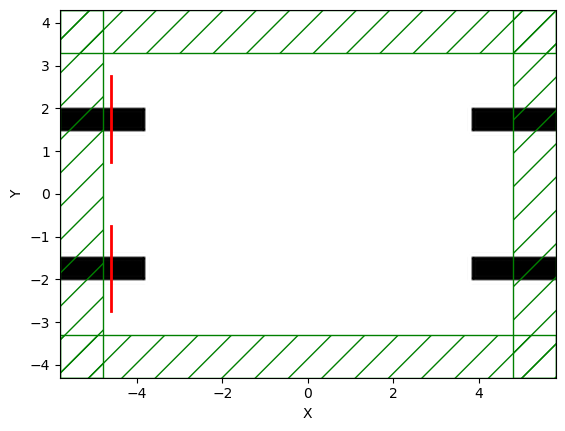

In [4]:
Sx = 2*pml_size + waveguide_length/2 + design_region_length+1 # cell size in X
Sy = 2*pml_size + design_region_width + 2 # cell size in Y
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen#1/1.5 - 1/1.6#width * fcen
#source_center  = [-Sx/2 + pml_size + waveguide_length/3,arm_separation/2,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)

source_center1  = [-Sx/2 + pml_size+0.2 ,arm_separation/2,0]
source_center2  = [-Sx/2 + pml_size+0.2 ,-arm_separation/2,0]



src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

# src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
# source = [mp.EigenModeSource(src,
#                     eig_band = 1,
#                     direction=mp.NO_DIRECTION,
#                     eig_kpoint=kpoint,
#                     size = source_size,
#                     center=source_center)]

x_g = np.linspace(
    -design_region_length / 2,
    design_region_length / 2,
    Nx,
)
y_g = np.linspace(
    -design_region_width / 2,
    design_region_width / 2,
    Ny,
)
X_g, Y_g = np.meshgrid(
    x_g,
    y_g,
    sparse=True,
    indexing="ij",
)

tl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)
                                                      
tr_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (arm_separation + waveguide_width) / 2) & ( Y_g  >=(arm_separation - waveguide_width) / 2
)

br_wg_mask = (X_g >= design_region_length / 2 - filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)
                                                       
bl_wg_mask = (X_g <= -design_region_length / 2 + filter_radius) & (
    Y_g <= (-arm_separation + waveguide_width) / 2) & ( Y_g  >=(-arm_separation - waveguide_width) / 2
)                                                      
                                                     

Si_mask = tl_wg_mask | tr_wg_mask | br_wg_mask | bl_wg_mask

border_mask = (
    (X_g <= -design_region_length / 2 + filter_radius)
    | (X_g >= design_region_length / 2 - filter_radius)
    | (Y_g <= -design_region_width / 2 + filter_radius)
    | (Y_g >= design_region_width / 2 - filter_radius)
)
Air_mask = border_mask.copy()
Air_mask[Si_mask] = False


geometry = [
    mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top left waveguide
    mp.Block(center=mp.Vector3(x=-(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom left waveguide
    mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # top right waveguide
    mp.Block(center=mp.Vector3(x=(design_region_length+waveguide_length)/2, y=-arm_separation/2), material=Si, size=mp.Vector3(waveguide_length, waveguide_width, 0)), # bottom right waveguide
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)
sim.plot2D()

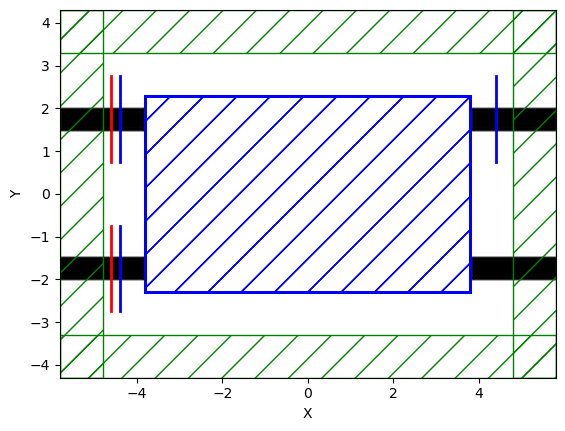

In [5]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(x=Sx/2 - pml_size - 0.4, y=arm_separation/2),
            size=source_size),mode)
TE_top = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,arm_separation/2,0),
            size=source_size),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,
        mp.Volume(center=mp.Vector3(-Sx/2 + pml_size + 0.4,-arm_separation/2,0),
            size=source_size),mode)
ob_list = [TE0,TE_top,TE_bottom]

def J(output,top_source,bottom_source):
    power = npa.abs(output) ** 2 / (npa.abs(top_source)**2 + npa.abs(bottom_source)**2)
    return 1-power

opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_functions = J,
    objective_arguments = ob_list,
    design_regions = [design_region],
    frequencies=frequencies
)
opt.plot2D(True)

In [6]:
evaluation_history = []
cur_iter = [0]
objfunc_history=[]
epivar_history=[]

def mapping(x: np.ndarray, eta: float, beta: float) -> np.ndarray:

    x = npa.where(Si_mask.flatten(), 1, npa.where(Air_mask.flatten(), 0, x.flatten()))

    x = (npa.fliplr(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # up-down symmetry
    x = (npa.flipud(x.reshape(Nx,Ny)) + x.reshape(Nx,Ny))/2 # left-right symmetry

    filtered_field = mpa.conic_filter(x, filter_radius,design_region_length,design_region_width,design_region_resolution)
    projected_field = mpa.tanh_projection(filtered_field,beta,eta)

    return projected_field.flatten()


def f(x, grad):
    t = x[0]  # "dummy" parameter
    v = x[1:]  # design parameters
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t



def c(result: np.ndarray, x: np.ndarray, gradient: np.ndarray, eta: float,
      beta: float):


    print(
        "Current iteration: {}; current eta: {}, current beta: {}".format(
            cur_iter[0], eta, beta
        )
    )

    
    t = x[0]  # epigraph variable
    v = x[1:]  # design weights

    f0, dJ_du = opt([mapping(v, eta, beta)])


        # Backprop the gradients through our mapping function
    my_grad = np.zeros(dJ_du.shape)
    
    for k in range(nf):
        my_grad[:, k] = tensor_jacobian_product(mapping, 0)(v, eta, beta, dJ_du[:, k])

    # Assign gradients
    if gradient.size > 0:
        gradient[:, 0] = -1  # gradient w.r.t. "t"
        gradient[:, 1:] = my_grad.T  # gradient w.r.t. each frequency objective

    result[:] = np.real(f0) - t

    # store results
    evaluation_history.append(np.real(f0))
    epivar_history.append(t)

    # visualize
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1


<Axes: xlabel='X', ylabel='Y'>

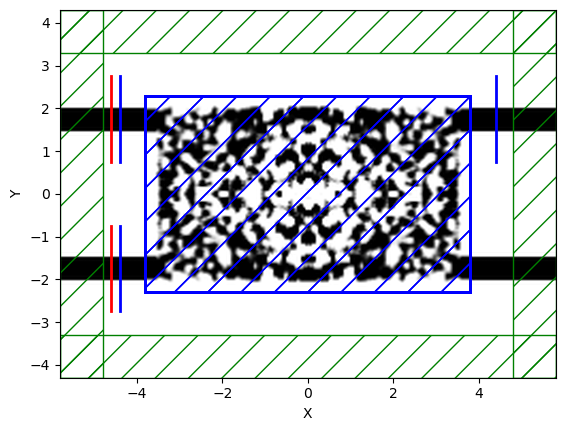

In [7]:
design_region.update_design_parameters(mapping(np.random.rand(Nx,Ny),0.5,99
                                            ))
sim.plot2D()

## Gradient visualization

In [ ]:
x0 = 0.5*np.ones((Nx,Ny)) #+ np.random.normal(loc=mean, scale=std, size=(Nx,Ny))

#just for the same of a boundary value
x0=np.where(x0>1,1,x0)
x0=np.where(x0<0,0,x0)

#x0 = np.random.rand(Nx,Ny)
f0, g0 = op([mapping(x0,0.5,2)])

In [ ]:
np.shape(g0.T)

In [ ]:
plt.figure()
print(g0.shape)
plt.imshow(np.rot90(g0[:,0].reshape(Nx,Ny)))
plt.colorbar()

In [ ]:
backprop_gradient = tensor_jacobian_product(mapping,0)(x0,0.5,2,g0[:,0])
plt.imshow(np.rot90(backprop_gradient.reshape(Nx,Ny)))
plt.colorbar()

## For the phase, 2 things must be considered: 
1. The top input and top output are inphase
2. The top input and top output had a phase difference of pi/2 with the bottom waveguide

That's why we use "Phase injected topology optimization" ( Read more here: https://pubs.acs.org/doi/abs/10.1021/acsphotonics.2c01016)

Current iteration: 0; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


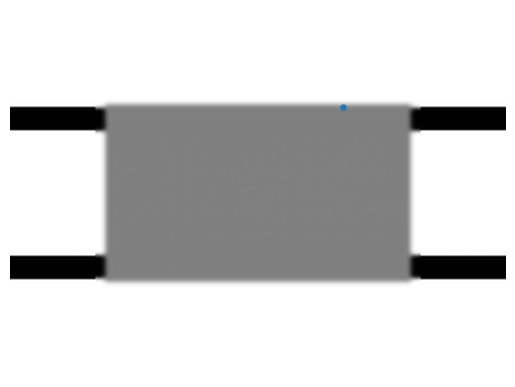

Current iteration: 1; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


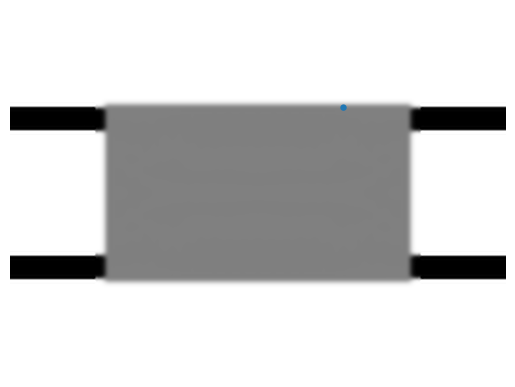

Current iteration: 2; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


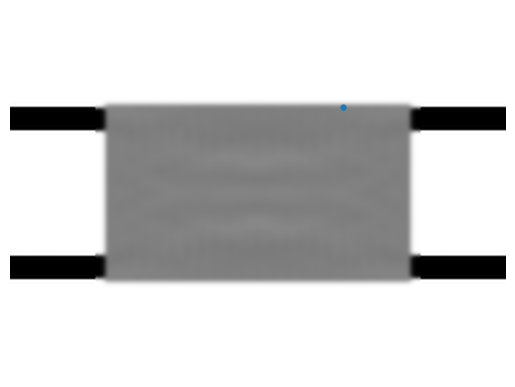

Current iteration: 3; current eta: 0.5, current beta: 4
Starting forward run...


/home/satadrudas/anaconda3/envs/meep/lib/python3.11/site-packages/meep/geom.py:582: UserWarning: The weights parameter of MaterialGrid must be in the range [0,1].
  warnings.warn(


Starting adjoint run...
Calculating gradient...


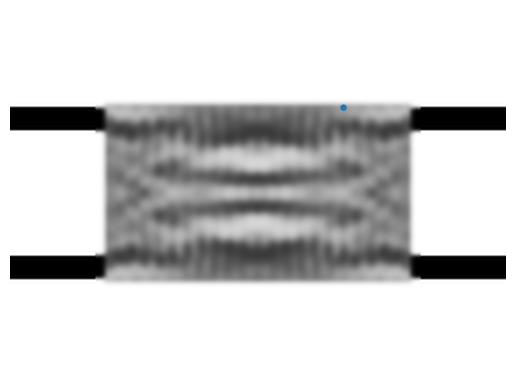

Current iteration: 4; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


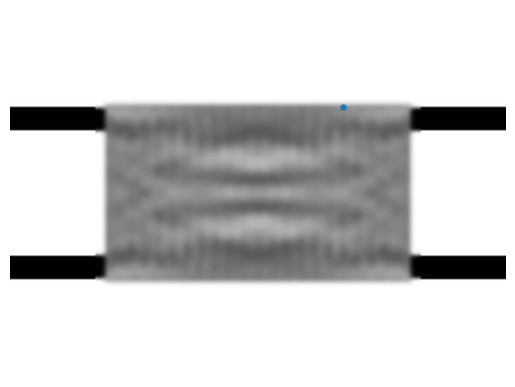

Current iteration: 5; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


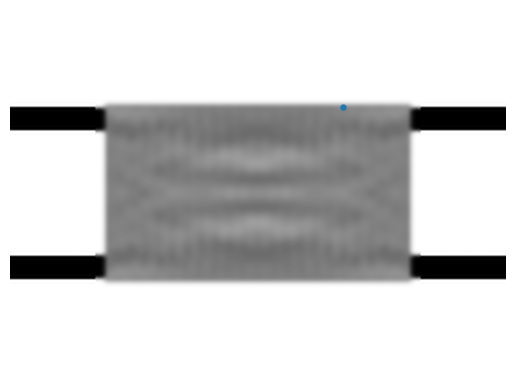

Current iteration: 6; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


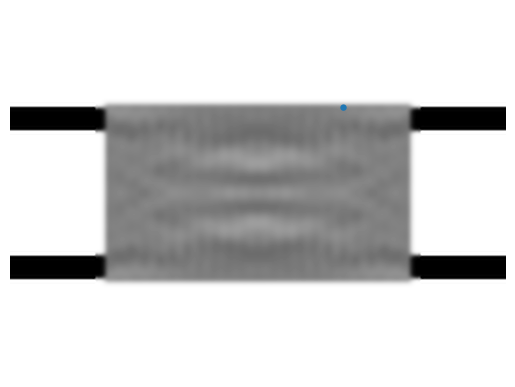

Current iteration: 7; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


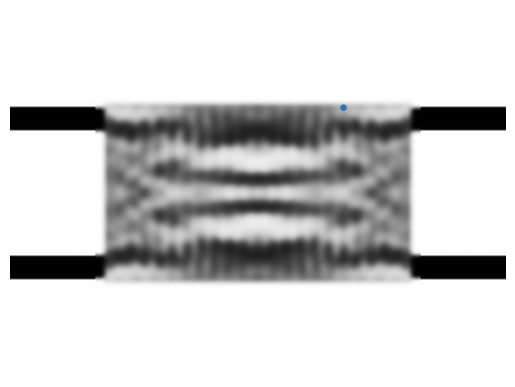

Current iteration: 8; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


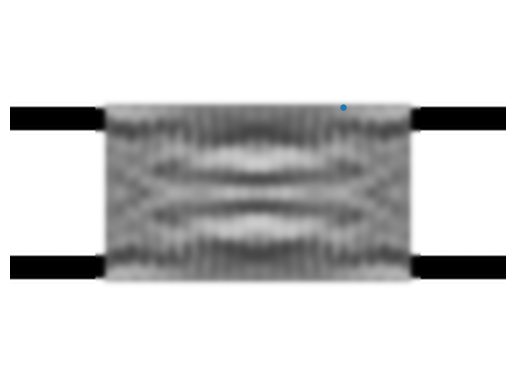

Current iteration: 9; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


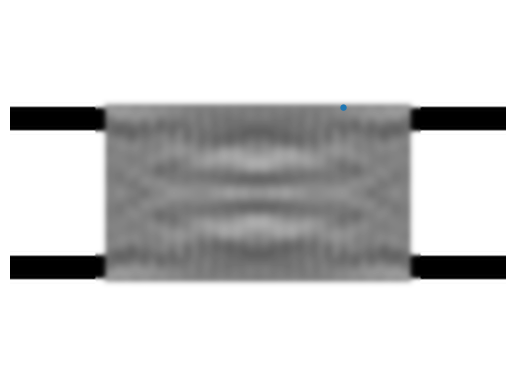

Current iteration: 10; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


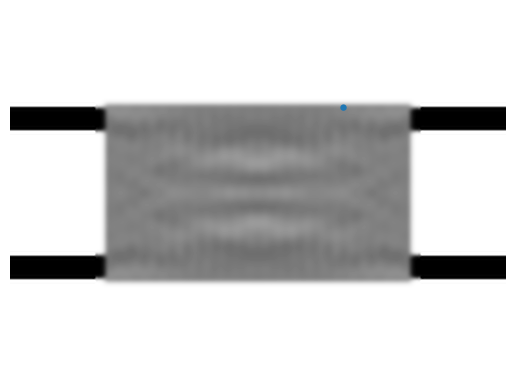

Current iteration: 11; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


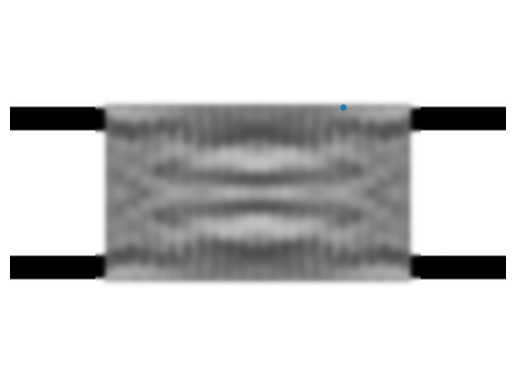

Current iteration: 12; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


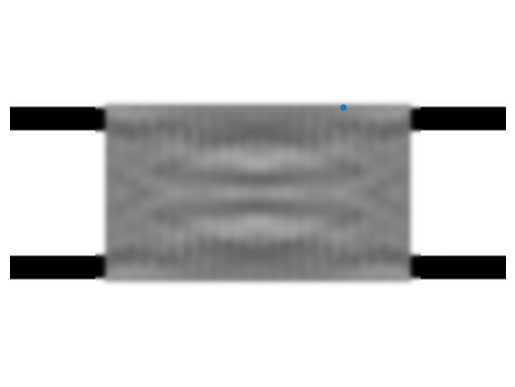

Current iteration: 13; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


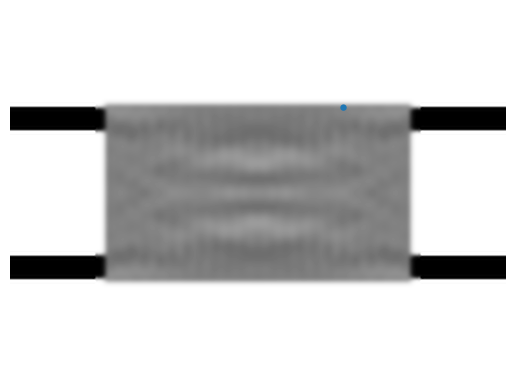

Current iteration: 14; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


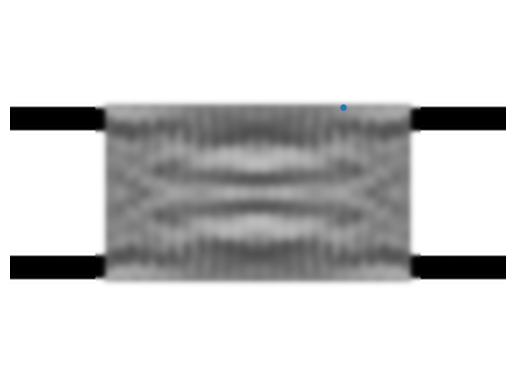

Current iteration: 15; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


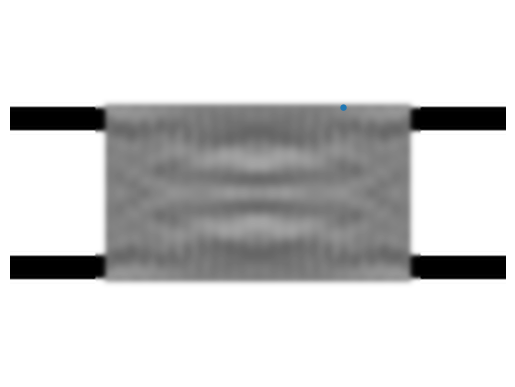

Current iteration: 16; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


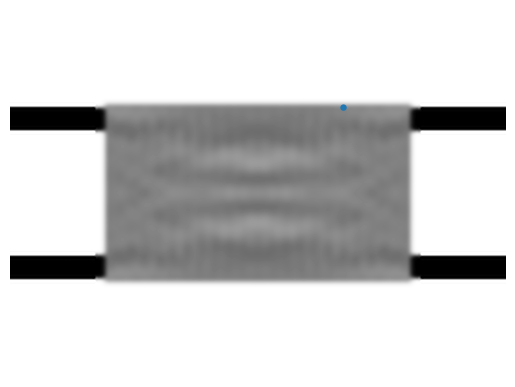

Current iteration: 17; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


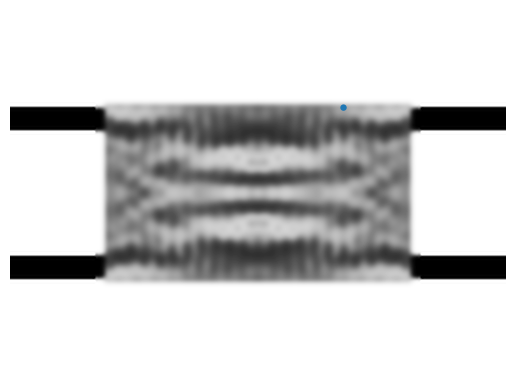

Current iteration: 18; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


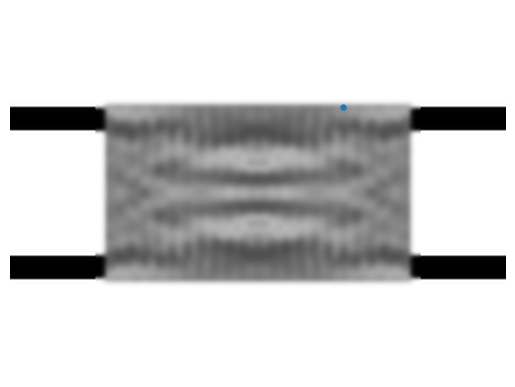

Current iteration: 19; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


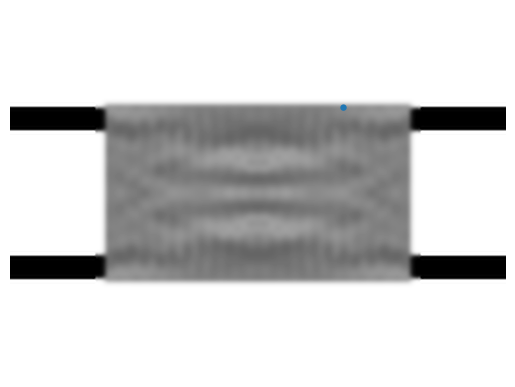

Current iteration: 20; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


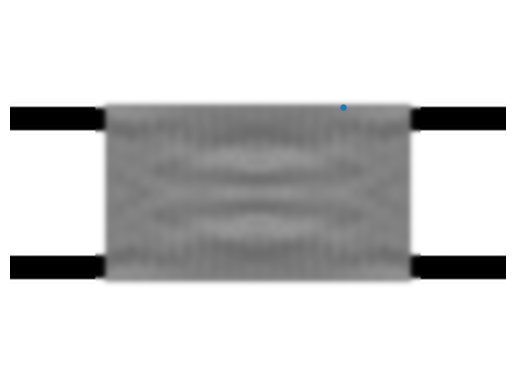

Current iteration: 21; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


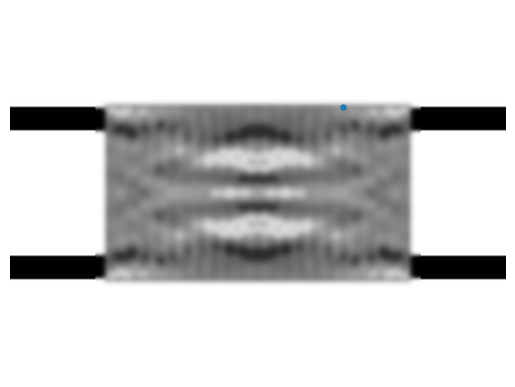

Current iteration: 22; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


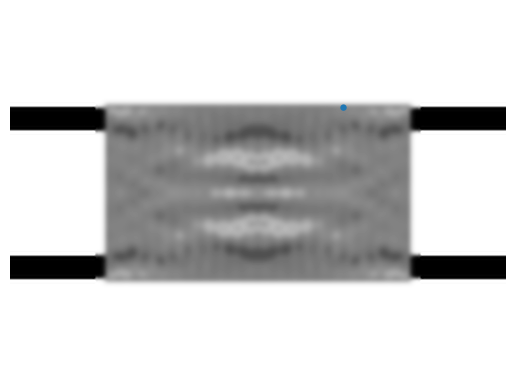

Current iteration: 23; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


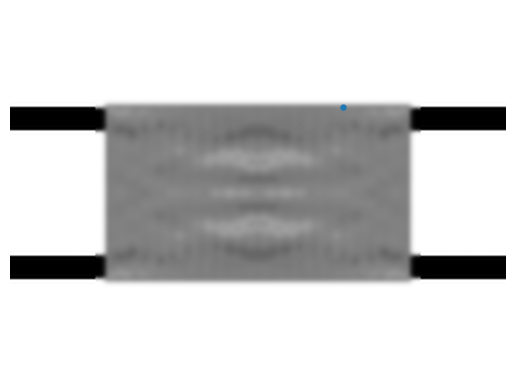

Current iteration: 24; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


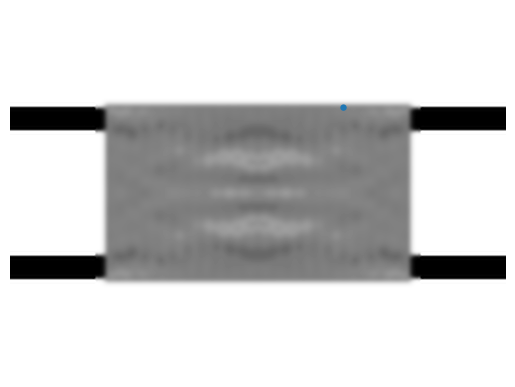

Current iteration: 25; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


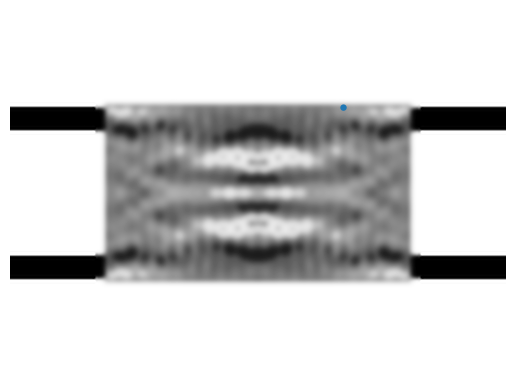

Current iteration: 26; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


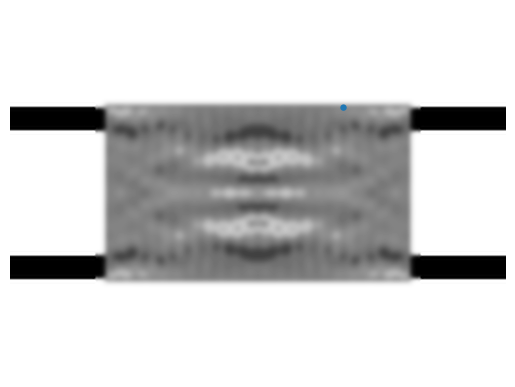

Current iteration: 27; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


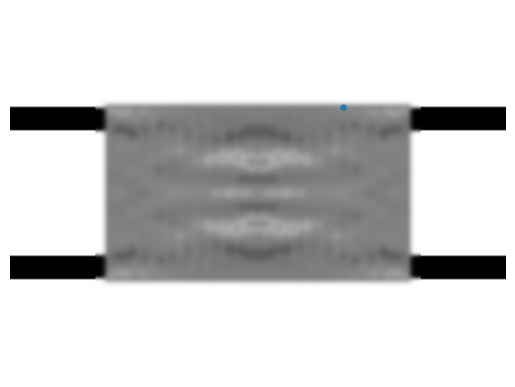

Current iteration: 28; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


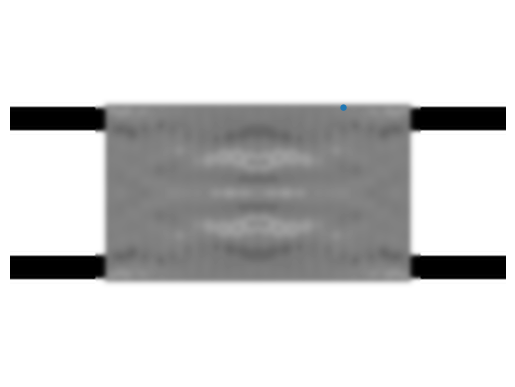

Current iteration: 29; current eta: 0.5, current beta: 4
Starting forward run...
Starting adjoint run...
Calculating gradient...


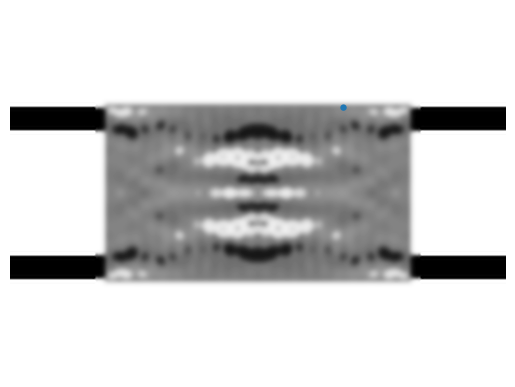

Current iteration: 30; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


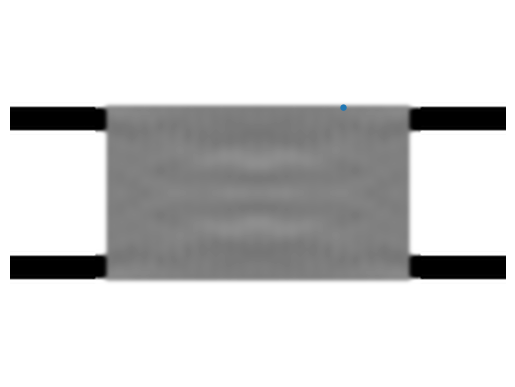

Current iteration: 31; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


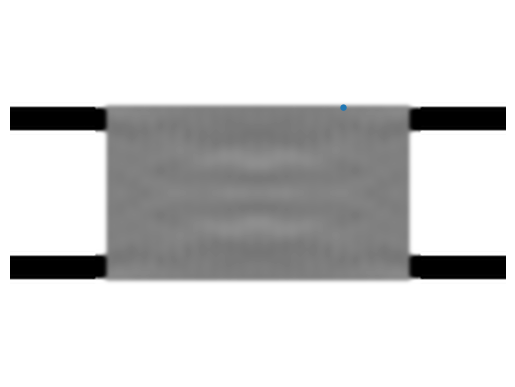

Current iteration: 32; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


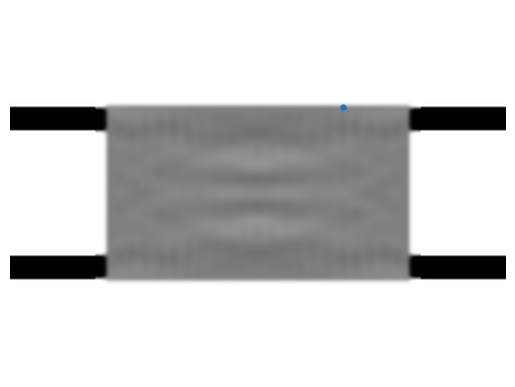

Current iteration: 33; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


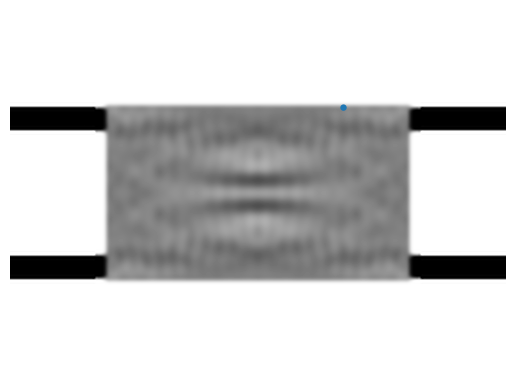

Current iteration: 34; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


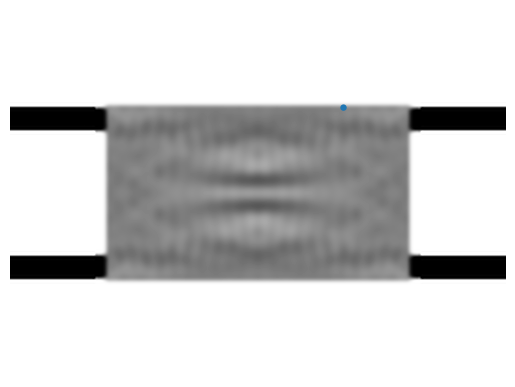

Current iteration: 35; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


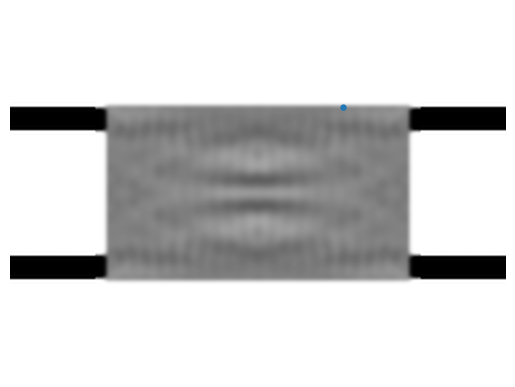

Current iteration: 36; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


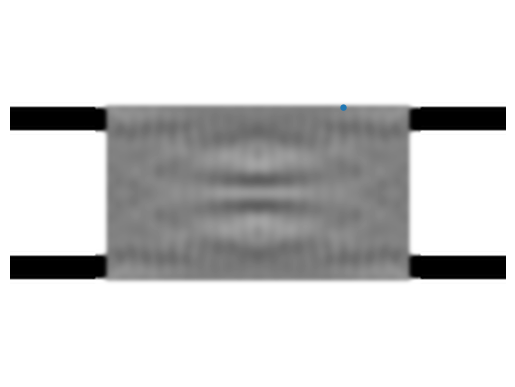

Current iteration: 37; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


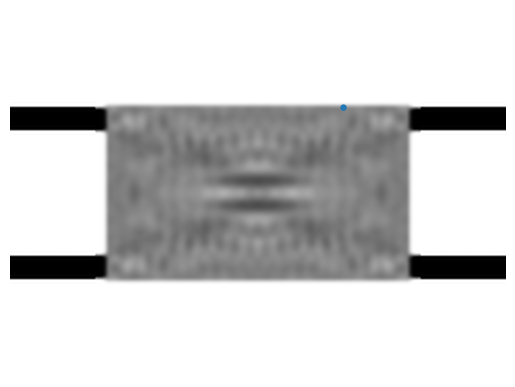

Current iteration: 38; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


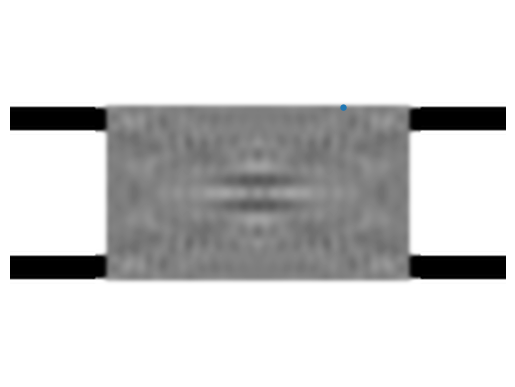

Current iteration: 39; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


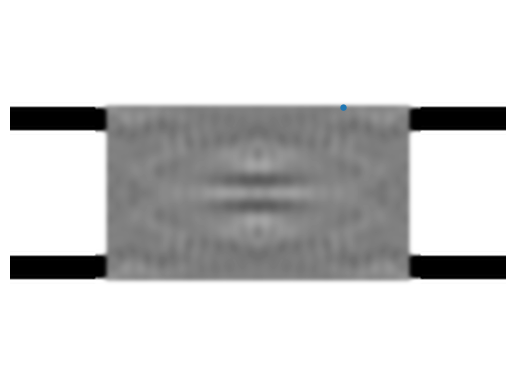

Current iteration: 40; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


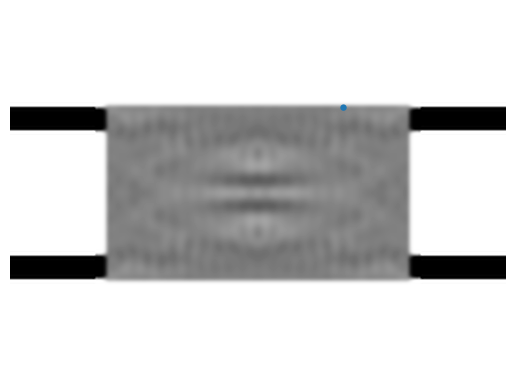

Current iteration: 41; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


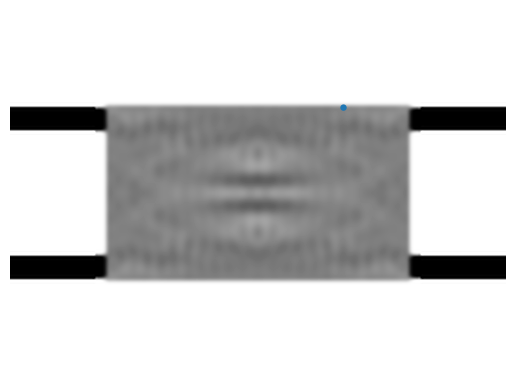

Current iteration: 42; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


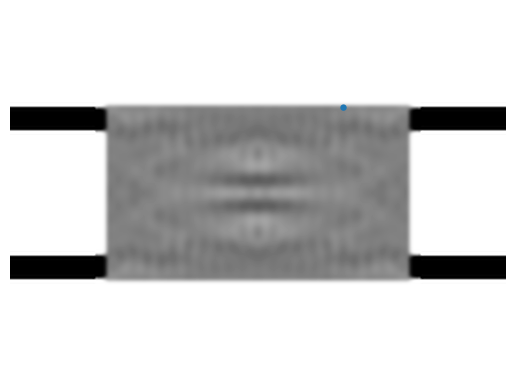

Current iteration: 43; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


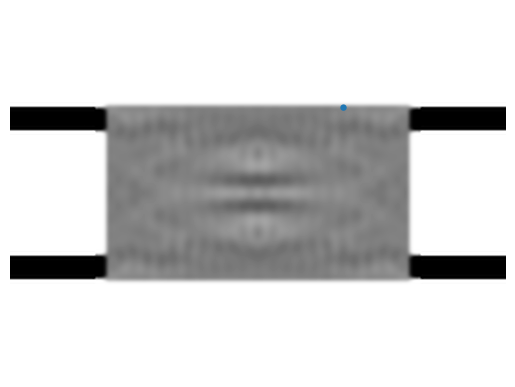

Current iteration: 44; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


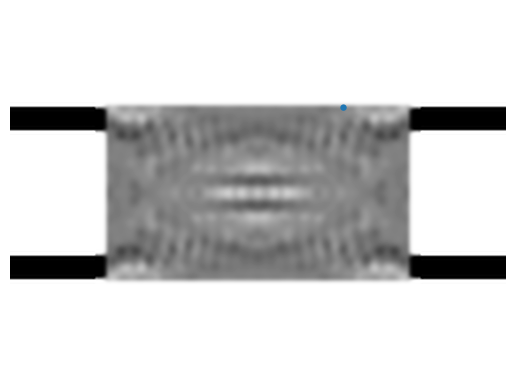

Current iteration: 45; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


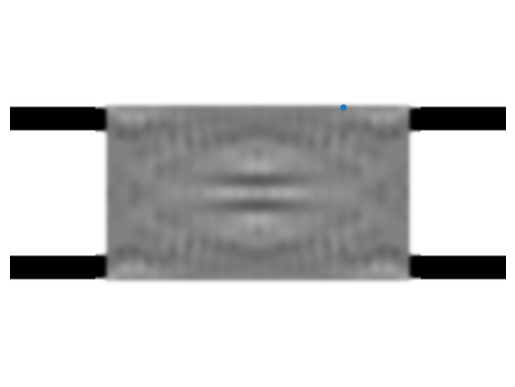

Current iteration: 46; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


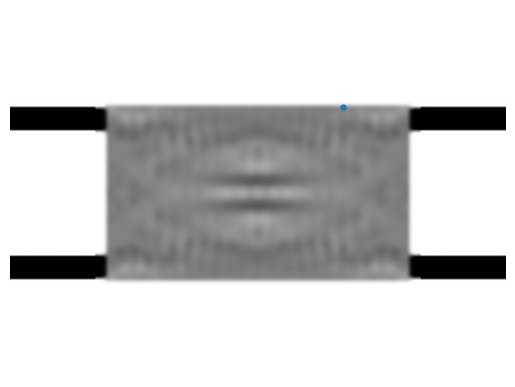

Current iteration: 47; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


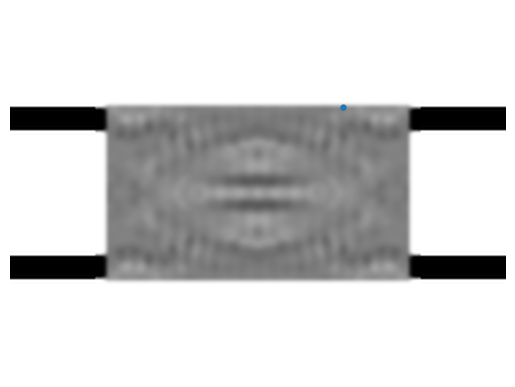

Current iteration: 48; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


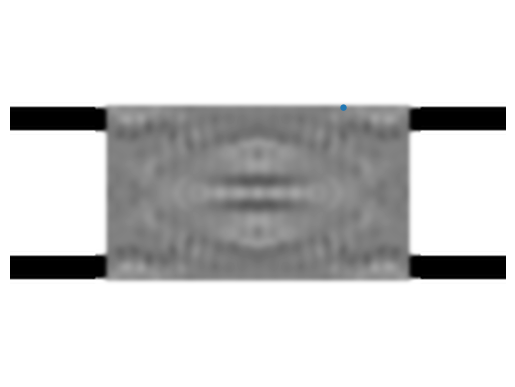

Current iteration: 49; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


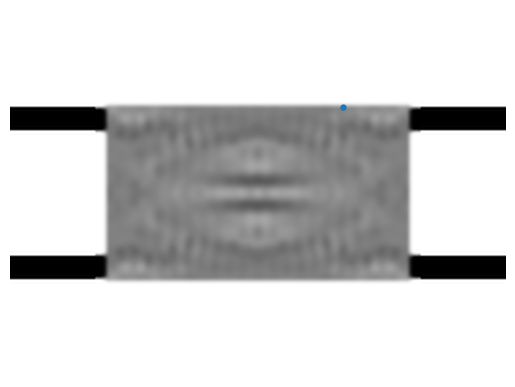

Current iteration: 50; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


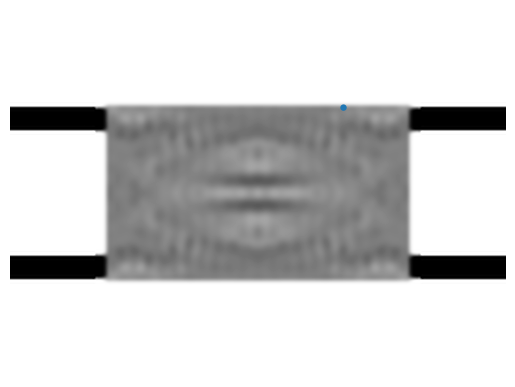

Current iteration: 51; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


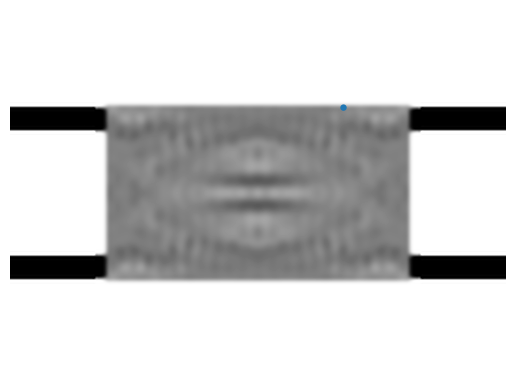

Current iteration: 52; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


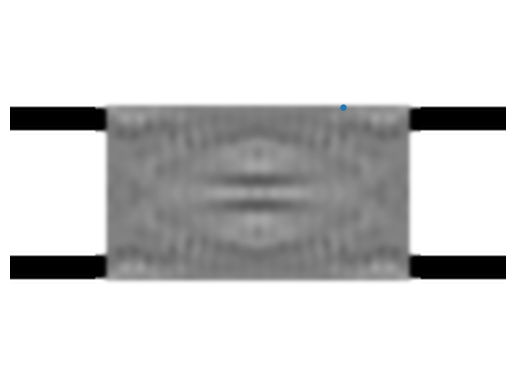

Current iteration: 53; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


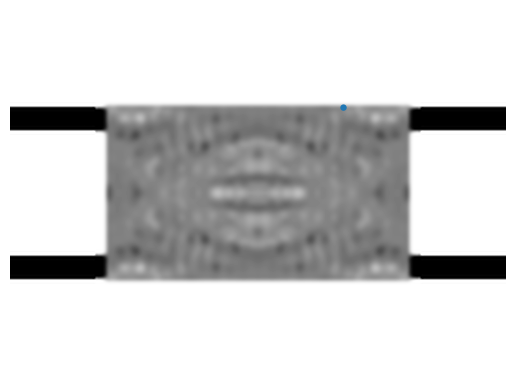

Current iteration: 54; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


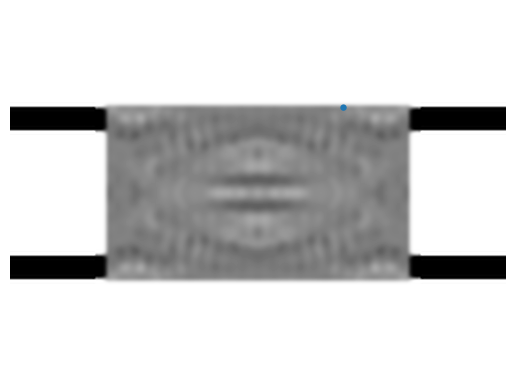

Current iteration: 55; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


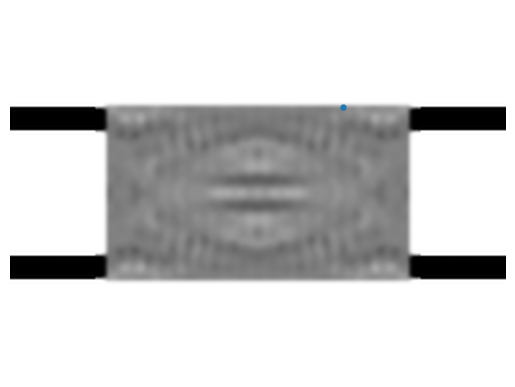

Current iteration: 56; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


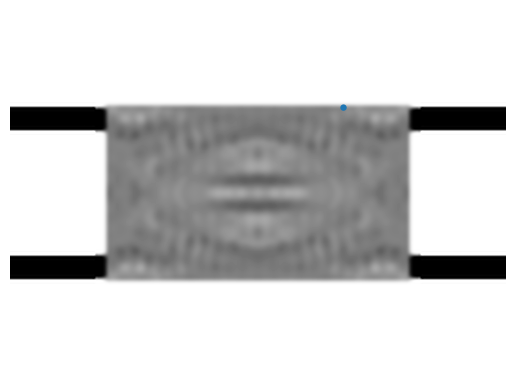

Current iteration: 57; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


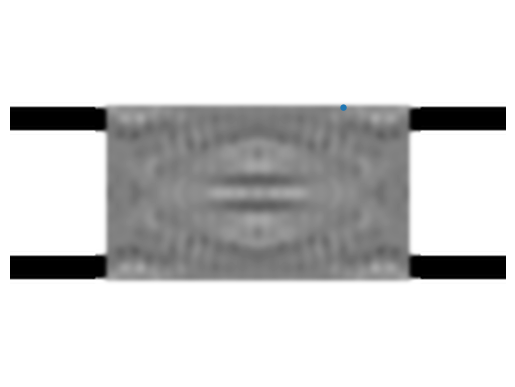

Current iteration: 58; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


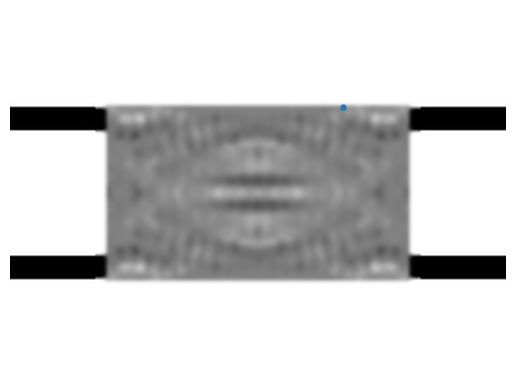

Current iteration: 59; current eta: 0.5, current beta: 8
Starting forward run...
Starting adjoint run...
Calculating gradient...


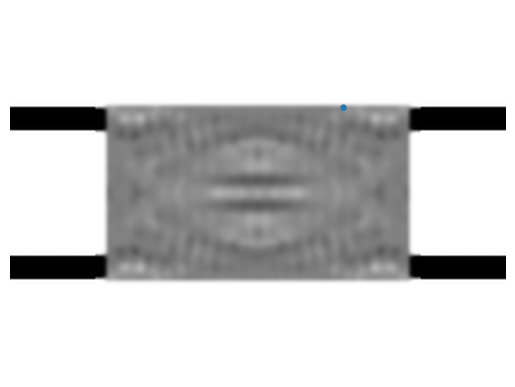

Current iteration: 60; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


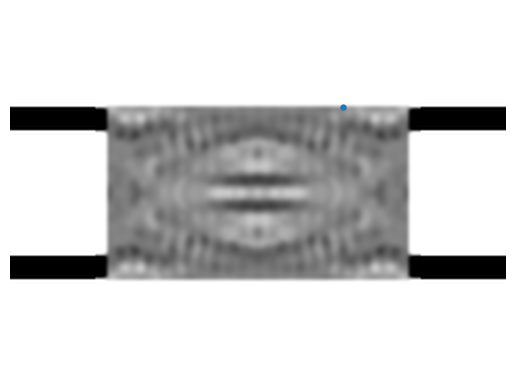

Current iteration: 61; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


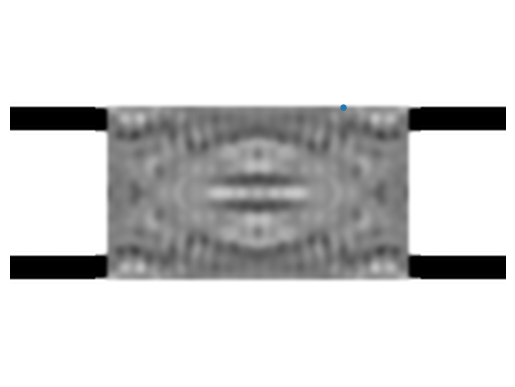

Current iteration: 62; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


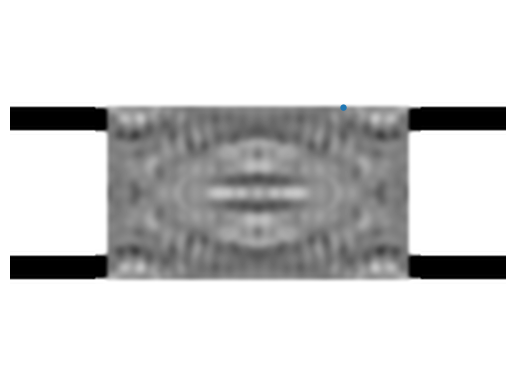

Current iteration: 63; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


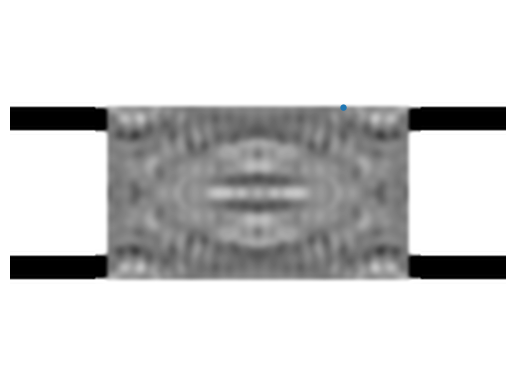

Current iteration: 64; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


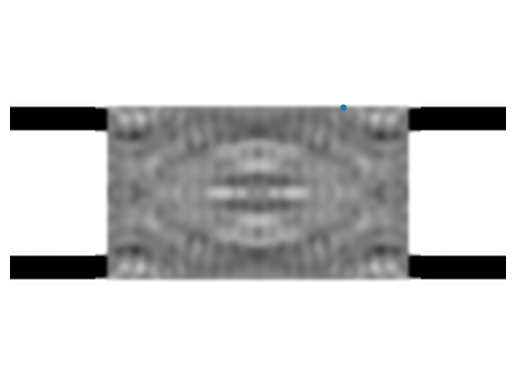

Current iteration: 65; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


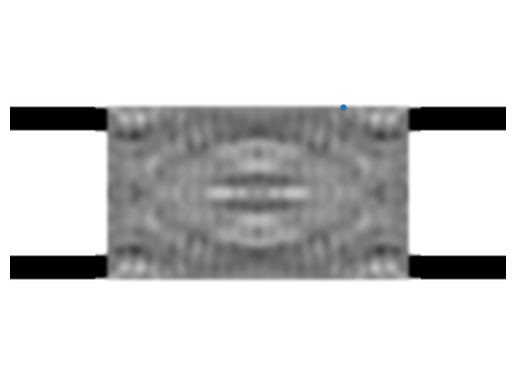

Current iteration: 66; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


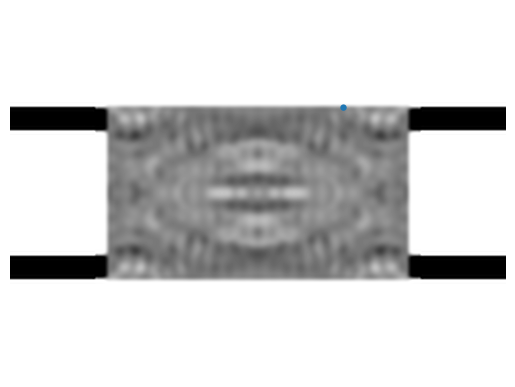

Current iteration: 67; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


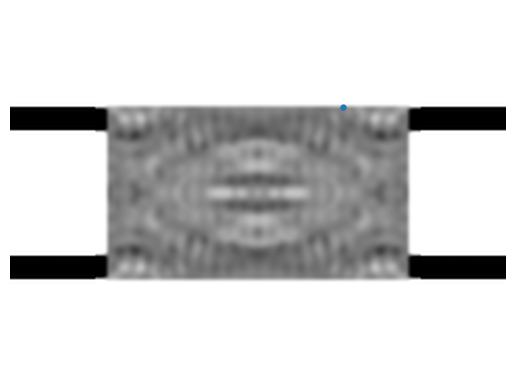

Current iteration: 68; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


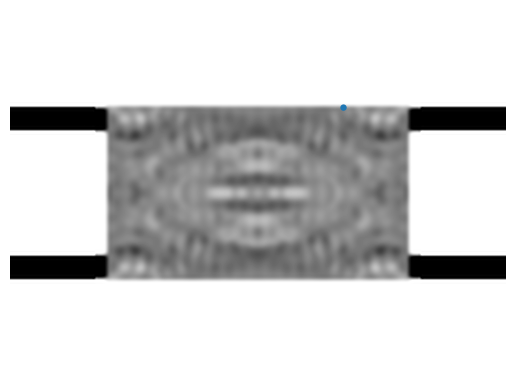

Current iteration: 69; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


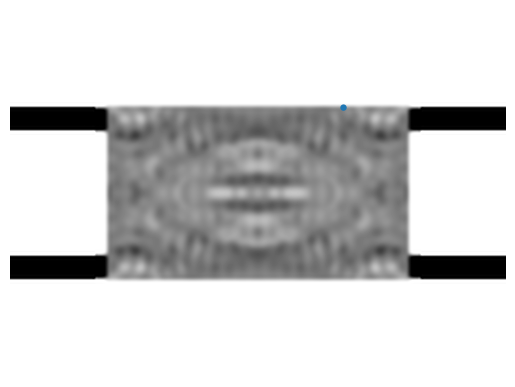

Current iteration: 70; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


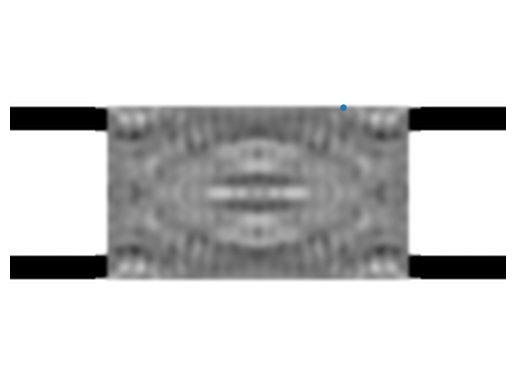

Current iteration: 71; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


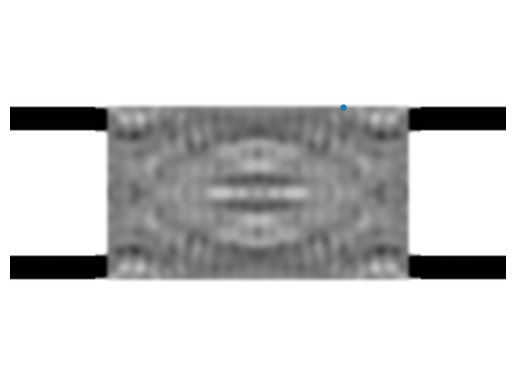

Current iteration: 72; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


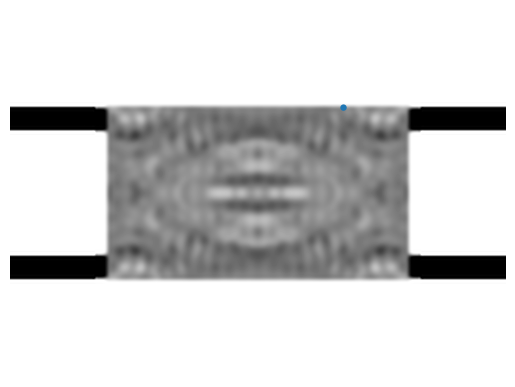

Current iteration: 73; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


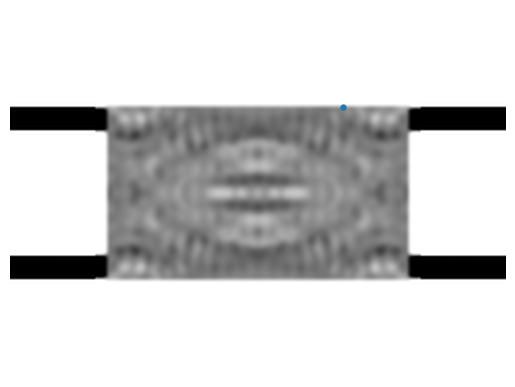

Current iteration: 74; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


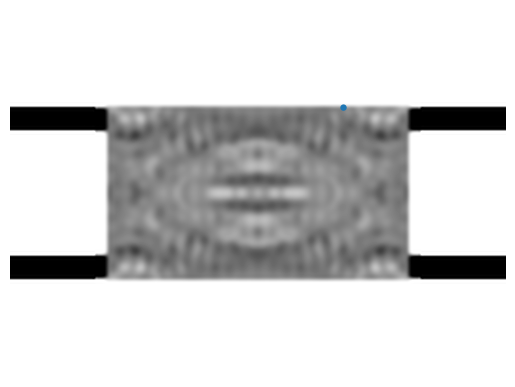

Current iteration: 75; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


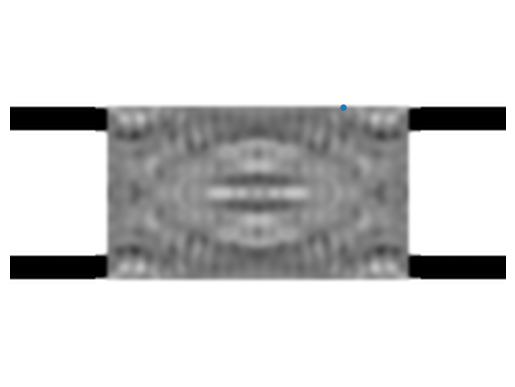

Current iteration: 76; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


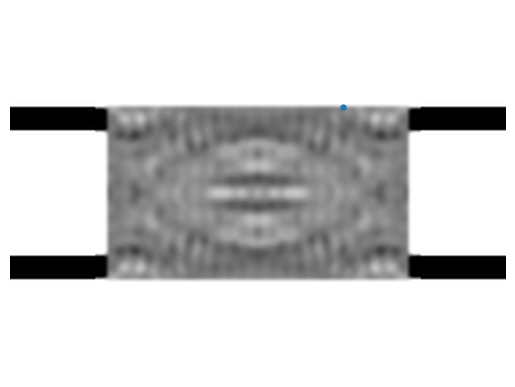

Current iteration: 77; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


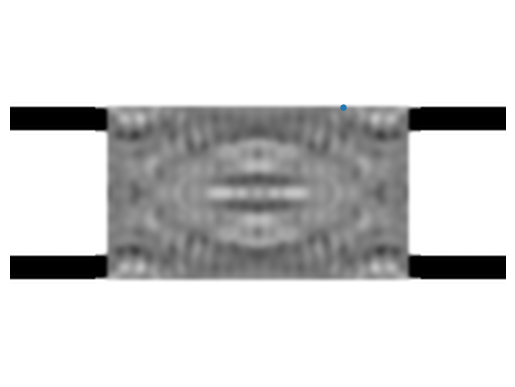

Current iteration: 78; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


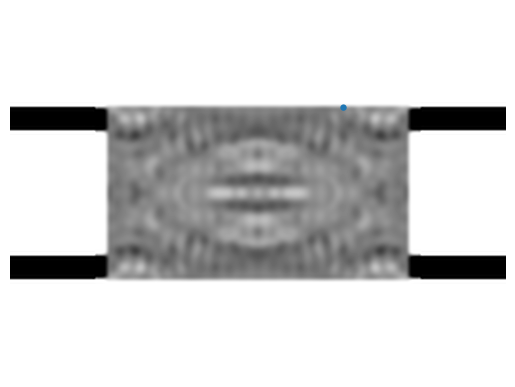

Current iteration: 79; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...
Calculating gradient...


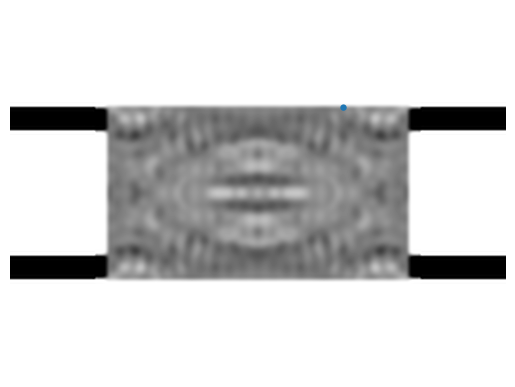

Current iteration: 80; current eta: 0.5, current beta: 16
Starting forward run...
Starting adjoint run...


In [8]:
algorithm = nlopt.LD_MMA

n = Nx * Ny

# initial design parameters
x = np.ones((n,)) * 0.5 #+ np.random.normal(loc=mean, scale=std, size=(n,))
x[Si_mask.flatten()] = 1.0  # set the edges of waveguides to silicon
x[Air_mask.flatten()] = 0.0  # set the other edges to SiO2

# lower and upper bounds for design weights
lb = np.zeros((n,))
lb[Si_mask.flatten()] = 1.0
ub = np.ones((n,))
ub[Air_mask.flatten()] = 0.0

# insert dummy parameter bounds and variable
x = np.insert(x, 0, 0.5)  # our initial guess for the worst error
lb = np.insert(lb, 0, 0)  # we can't get less than 0 error!
ub = np.insert(ub, 0, 1)  # we can't get more than 1 error!


objfunc_history = []
epivar_history = []
cur_iter = [0]

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 30
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n + 1)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_min_objective(f)
    solver.set_maxeval(update_factor)
    solver.add_inequality_mconstraint(
        lambda r, x, g: c(r, x, g, eta_i, cur_beta), np.array([1e-6] * nf)
    )
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

In [ ]:
#################################################
#SAVE THE design_region (x)
#################################################

np.save("design_dc_minimax_lc.npy",x[1:])

In [ ]:
plt.matshow(x[1:].reshape(Nx,Ny))

In [ ]:
epivar_history=np.array(epivar_history)
np.save("epivar_history_lc.npy",epivar_history)
plt.figure()
plt.plot(epivar_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Epivar')
plt.show()


In [ ]:
lb = 1 - np.min(evaluation_history, axis=1)
ub = 1 - np.max(evaluation_history, axis=1)
mean = 1 - np.mean(evaluation_history, axis=1)

num_iters = lb.size

plt.figure()
plt.fill_between(
    np.arange(1, num_iters + 1), 10 * np.log10(lb), 10 * np.log10(ub), alpha=0.3
)
plt.plot(10 * np.log10(mean), "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Average Insertion Loss (dB)")
plt.show()

In [ ]:
evaluation_history=np.array(evaluation_history)
np.save("evaluation_history.npy",evaluation_history)

plt.figure()
plt.plot(10*np.log10(1-evaluation_history),'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Insertion Loss (dB)')
plt.show()

In [ ]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Evaluation History')
plt.show()

In [ ]:
final_sim,geometry=dc_final_design_sim(beta=betas[-1])
final_sim.plot2D(True)

In [ ]:
f0, dJ_du = final_sim([mapping(x[1:],eta_i,betas[-1])],need_gradient = False)
frequencies = opt.frequencies
source_coef, top_coef, bottom_coef = opt.get_objective_arguments()



In [ ]:
top_profile = np.abs(top_coef/source_coef) ** 2
bottom_profile = np.abs(bottom_ceof/source_coef) ** 2

In [ ]:
plt.figure()
plt.plot(1/frequencies,top_profile*100,'-o' ,label = 'Top Arm')
plt.plot(1/frequencies,bottom_profile*100,'--o',label = 'Bottom Arm')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Power Splitting Ratio (%)')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,1-(np.abs(top_coef) ** 2 + np.abs(bottom_ceof) ** 2)/np.abs(source_coef) ** 2,'-o' ,label = 'Insertion loss')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Insertion loss')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
plt.figure()
plt.plot(1/frequencies,(np.abs(top_coef) ** 2 / np.abs(bottom_ceof) ** 2) ** 2,'-o' ,label = 'Output ration')
plt.legend()
plt.grid(True)
plt.xlabel('Wavelength (microns)')
plt.ylabel('Output power ration')
#plt.ylim(46.5,50)
plt.show()

In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center1,
    )
]
final_sim.sim.change_sources(source)
final_sim.sim.run(until=500)
final_sim.sim.plot2D(fields=mp.Ez)

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

In [ ]:
plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=150)
plt.close()

In [ ]:
filename = "dc_2d_15x4_1s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)


In [ ]:
src = mp.ContinuousSource(frequency=1 / 1.55, fwidth=fwidth)
sources = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center1,
                    amplitude=1.0),
            mp.EigenModeSource(
                    src,
                    eig_band=1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size=source_size,
                    center=source_center2,
                    amplitude=0.0 - 1.0j
    )]

In [ ]:
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    #symmetries=[mp.Mirror(direction=mp.Y)],
                    default_material=mp.air,
                    resolution=resolution)

plt.figure(dpi=100)
sim.plot2D()
plt.show()

In [ ]:
sim.run(until=300)


In [ ]:
plt.figure(dpi=120)
sim.plot2D(fields=mp.Ez)
plt.show()

In [ ]:
sim.reset_meep()
f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True)
plt.close()

In [ ]:
sim.run(mp.at_every(1, Animate), until=300)
plt.close()

In [ ]:
filename = "dc_2d_15x4_2s.mp4"
Animate.to_mp4(10, filename)

In [ ]:
Video(filename)
